# Training Predictive Model

### Import libraries

In [1]:
import datetime
import json
import random
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import pytorch_lightning as pl

from pathlib import Path
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from ray import tune
from pytorch_lightning.loggers import TensorBoardLogger
from Models import FaceDataset, create_datasets, SingleModel, EyesModel, FullModel
from utils import get_config, train_single, train_eyes, train_full, tune_asha, get_best_results, get_tune_results, save_model, predict_screen_errors

SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")

%load_ext autoreload

### Dataset information

In [2]:
df = pd.read_csv('data/positions.csv')
region_map = np.load("data/region_map.npy").T

print("# of images: {}".format(len(df)))
print("Coverage: {}%".format(round(np.count_nonzero(region_map > 0) / region_map.size * 100, 2)))
print("Image dimensions: {}x{}px".format(SETTINGS["image_size"], SETTINGS["image_size"]))

# of images: 20050
Coverage: 61.77%
Image dimensions: 256x256px


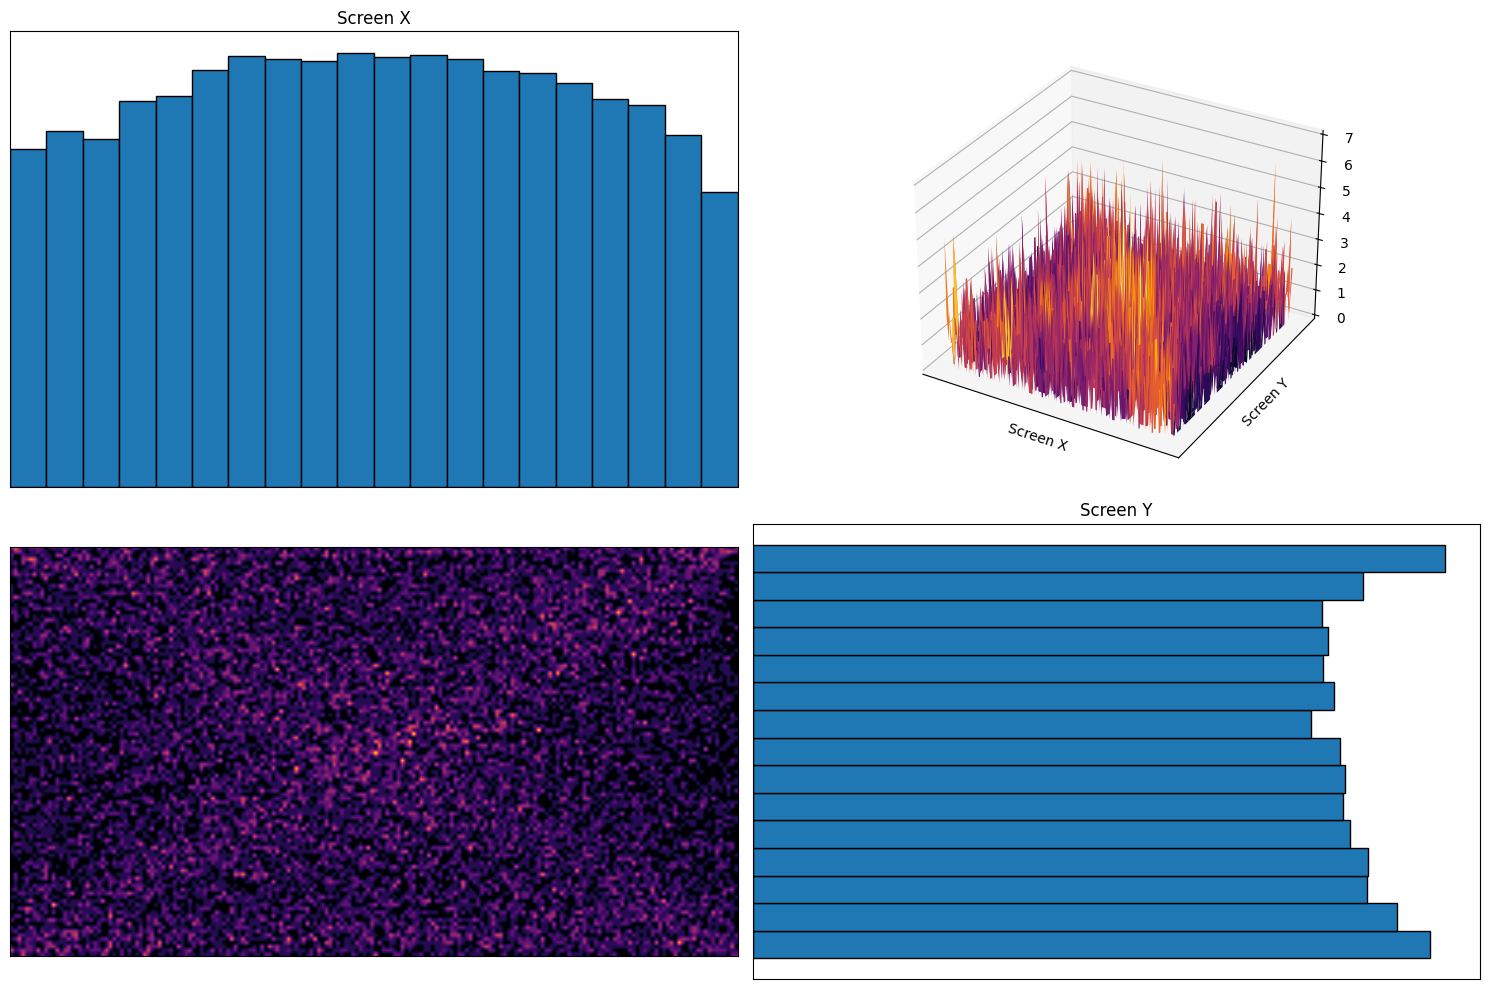

In [3]:
x = np.arange(region_map.shape[1])
y = np.arange(region_map.shape[0])
X, Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
ax.hist(df['x'], bins=20, edgecolor='k')
ax.set_title('Screen X')
ax.margins(x=0)

ax = fig.add_subplot(222, projection='3d')
ax.dist = 9
ax.plot_surface(X, Y, region_map, cmap="inferno")
ax.set_xlabel('Screen X', labelpad=-10)
ax.set_ylabel('Screen Y', labelpad=-10)

ax = fig.add_subplot(223)
ax.imshow(region_map, interpolation='bilinear', cmap="inferno")

ax = fig.add_subplot(224)
ax.hist(df['y'], bins=15, edgecolor='k', orientation='horizontal')
ax.set_title('Screen Y')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.savefig('media/images/0_data_distribution.png')
plt.show()

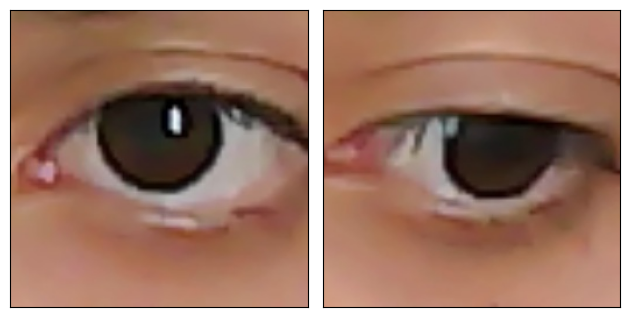

In [4]:
low_bright = mpimg.imread('data/r_eye/12.jpg')
high_bright = mpimg.imread('data/r_eye/31.jpg')
fig, axs = plt.subplots(1, 2)
axs[0].imshow(low_bright)
axs[1].imshow(high_bright)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()

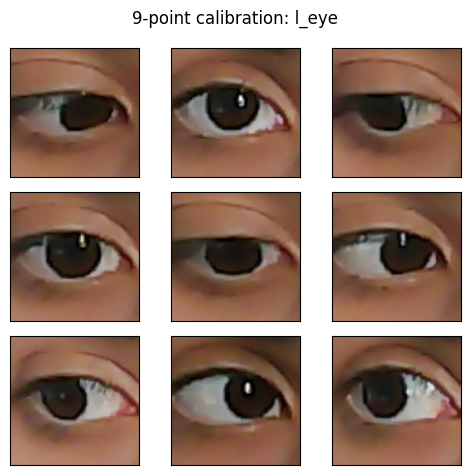

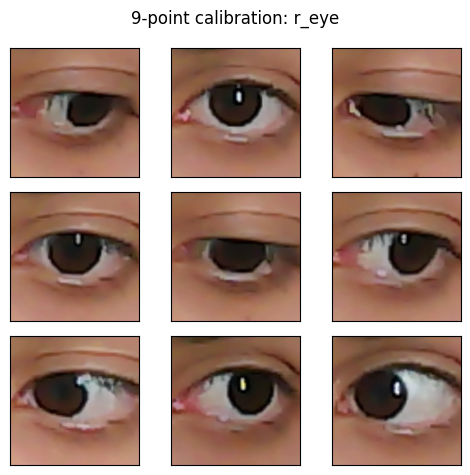

In [5]:
def plot_calibration(eye):
    calibration = [mpimg.imread('data/{}/{}.jpg'.format(eye, i)) for i in range(1,10)]
    fig, axs = plt.subplots(3, 3)
    axs[0,0].imshow(calibration[3])
    axs[0,1].imshow(calibration[6])
    axs[0,2].imshow(calibration[8])

    axs[1,0].imshow(calibration[2])
    axs[1,1].imshow(calibration[4])
    axs[1,2].imshow(calibration[7])

    axs[2,0].imshow(calibration[1])
    axs[2,1].imshow(calibration[0])
    axs[2,2].imshow(calibration[5])

    plt.suptitle("9-point calibration: {}".format(eye))
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.subplots_adjust(hspace=50)
    plt.tight_layout()
    plt.savefig('media/images/0_calibration_{}.png'.format(eye))
    plt.show()

plot_calibration('l_eye')
plot_calibration('r_eye')

In [6]:
config = {
        "seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
        "bs": tune.choice([1 << i for i in range(2, 9)]),  # batch size
        "lr": tune.loguniform(1e-7, 1e-3),  # learning rate
        "filter_size": tune.choice([3, 5, 7, 9]),  # filter size (square)
        "filter_growth": tune.choice([1, 2]),  # increase filter count by a factor
        "n_filters": tune.choice([8, 16, 32, 64]),  # number of starting filters
        "n_convs": tune.choice([0, 1, 2]),  # number of conv layers
        "dense_nodes": tune.choice([16, 32, 64, 128]),  # number of nodes in fc layer
    }

analysis = tune_asha(config, data_partial=True, train_func=train_single, name="face/explore", img_types=["face"], num_samples=100, num_epochs=10, seed=87)

2025-04-08 22:11:06,424	INFO worker.py:1852 -- Started a local Ray instance.
2025-04-08 22:11:09,767	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-04-08 22:11:09,770	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
(train_single pid=12156) Seed set to 8525
2025-04-08 22:11:20,370	ERROR tune_controller.py:1331 -- Trial task failed for trial train_single_9c9e9_00000
Traceback (most recent call last):
  File "c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\.venv\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\.venv\Lib\site-packages\ray\_private\auto_in

Best hyperparameters: None


In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"1_face_explore_training.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"1_face_explore_scatter.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"1_face_explore_parallel.png")

In [ ]:
config = {
        "seed": tune.randint(0, 10000),  # reproducible random seed for each experiment
        "bs": tune.choice([1 << i for i in range(2, 7)]),  # batch size
        "lr": tune.loguniform(1e-4, 1e-3),  # learning rate
        "filter_size": tune.choice([3, 5, 7, 9]),  # filter size (square)
        "filter_growth": tune.choice([1, 2]),  # increase filter count by a factor
        "n_filters": tune.choice([8, 16, 32]),  # number of starting filters
        "n_convs": tune.choice([1, 2]),  # number of conv layers
        "dense_nodes": tune.choice([32, 64, 128]),  # number of nodes in fc layer
    }

analysis = tune_asha(config, data_partial=True, train_func=train_single, name="face/tune", img_types=["face"], num_samples=50, num_epochs=20, seed=87)

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"2_face_tune_scatter.png")

In [ ]:
IPython.display.Image(Path.cwd()/"media"/"images"/"2_face_tune_parallel.png")

In [ ]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

config = get_best_results(Path.cwd()/"logs"/"face"/"tune")

pl.seed_everything(config["seed"])

d_train, d_val, d_test = create_datasets(Path.cwd(), data_partial=True, img_types=["face"], seed=config["seed"], batch_size=config["bs"])

model = SingleModel(config, "face")
trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    accelerator="dp",
    checkpoint_callback=True,
    logger=TensorBoardLogger(save_dir=Path.cwd()/"logs", name="face/final/{}".format(start_time), log_graph=True))

trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)

save_model(model, config, 
           Path.cwd()/"logs"/"face"/"final"/"{}".format(start_time)/"eyetracking_model.pt", 
           Path.cwd()/"logs"/"face"/"final"/"{}".format(start_time)/"eyetracking_config.json")

In [ ]:
test_results = trainer.test(test_dataloaders=d_test)
print(f"Pixel error: {np.sqrt(test_results[0]['test_loss'])}")